In [1]:
'''
benchmark test for algorithms' efficiency
'''
# fixed random state
# 95% accuracy
# test accuracy increase
# test training time
# no learning rate tweaking

"\nbenchmark test for algorithms' efficiency\n"

In [2]:
# import
import tensorflow as tf
import numpy as np
from skimage.transform import rotate
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from tensorflow.contrib.layers import fully_connected
from datetime import datetime
from time import time

In [3]:
# global variables that doesn't need to be updated every run
np_seed = 4
tf_seed = 11

In [8]:
# variables that need to be changed
method = "dataAug"
size_multiple = 3

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


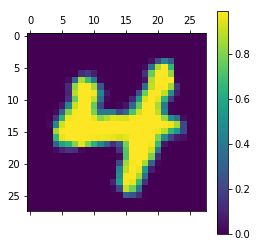

0.219477862508
(180000, 784) (180000,)
0.130524498159


In [5]:
# prepare data
np.random.seed(np_seed)
mnist = fetch_mldata("MNIST original")
train_size = 60000
X_train, X_test, y_train, y_test = train_test_split(mnist.data/256, mnist.target.astype(int), train_size=train_size,shuffle=True)

# augment data
def augment_data(X_train,y_train): # I made a function so that temp memory will be free after the function terminates
    rotation_angle = 10
    rotate_left = []
    rotate_right = []
    for i in range(train_size):
        img = X_train[i].reshape([28,28])
        rotate_left.append(rotate(img,rotation_angle).reshape(784))
        rotate_right.append(rotate(img,-rotation_angle).reshape(784))
        if(i%5000==0): print(i)

    rotate_left = np.asarray(rotate_left)
    rotate_right = np.asarray(rotate_right)
    
    X_train=np.concatenate([X_train,rotate_left,rotate_right])
    y_train=np.concatenate([y_train,y_train,y_train])
    return [X_train,y_train]
    

X_train, y_train = augment_data(X_train,y_train)

# make sure things go well
plt.matshow(X_train[70000].reshape([28,28]))
plt.colorbar()
plt.show()
print(np.mean(X_train[70000]))

# shuffle
random_indice = np.random.permutation(size_multiple*train_size)
X_train, y_train = X_train[random_indice], y_train[random_indice]
print(X_train.shape,y_train.shape)
print(np.mean(X_train))

In [10]:
def fetch_batch(X,y,batch_size):
    random_indice = np.random.permutation(X.shape[0])[:batch_size]
    return [X[random_indice], y[random_indice]]
def get_lr(lr_start,epoch):
    return lr_start/(2**(epoch/100.))

In [11]:
# construction phase
now = datetime.utcnow().strftime("%y%m%d-%H%M")
root_logdir = "logs"
logdir_train = "{}/{}_{}_train".format(root_logdir, method, now)
logdir_test = "{}/{}_{}_test".format(root_logdir,method,now)
root_savedir = "checkpoints"
savedir = "{}/base-{}".format(root_savedir, now)

tf.reset_default_graph()
tf.set_random_seed(tf_seed) # set random seed
n_neurons = 50
lr_start = 0.1

X = tf.placeholder(tf.float64, shape=[None, 784])
y = tf.placeholder(tf.int64, shape=[None])
is_training = tf.placeholder(tf.bool, shape=(), name="is_training")
keep_prob = 0.75

with tf.variable_scope("forward"):
    dense_1 = fully_connected(X, 64, scope="dense_1")
    dense_2 = fully_connected(dense_1, 32, scope="dense_2")
    output = fully_connected(dense_2, 10, activation_fn=None, scope="output")
    
with tf.variable_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output, labels=y,name="xentropy")
    loss = tf.reduce_mean(xentropy,name="loss")
    
with tf.variable_scope("annealing"):
    lr = tf.placeholder(tf.float32, shape=(), name="learning_rate")
    
with tf.variable_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(lr)
    training_op = optimizer.minimize(loss)

with tf.variable_scope("eval"):
    pred = tf.argmax(output,axis=1,name="prediction")
    accuracy = tf.reduce_mean(tf.cast(tf.equal(pred,y),tf.float64))
with tf.variable_scope("save"):
    saver = tf.train.Saver()
    loss_summary = tf.summary.scalar("loss", loss)
    accuracy_summary = tf.summary.scalar("accuracy", accuracy)
    summary = tf.summary.merge_all()
    writer_test = tf.summary.FileWriter(logdir_test,tf.get_default_graph())
    writer_train = tf.summary.FileWriter(logdir_train,tf.get_default_graph())
# execution phase
with tf.Session() as sess:
    np.random.seed(np_seed) # set random seed
    start_running = time()
    sess.run(tf.global_variables_initializer())
    n_epochs = 100
    batch_size = 1000
    n_batches = int(np.ceil(X_train.shape[0]/batch_size))
    
    for epoch in range(n_epochs):
        lr_ = get_lr(lr_start,epoch)
        for batch in range(n_batches):
            X_batch, y_batch = fetch_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X:X_batch,y:y_batch,lr:lr_,is_training:True})
        if epoch%10==0:
            start_time = time()
            summary_test, loss_test,  accuracy_test  = sess.run([summary,loss,accuracy],feed_dict={X:X_test,y:y_test,is_training:False})
            writer_test.add_summary(summary_test,epoch*size_multiple)
            summary_train,loss_train,  accuracy_train  = sess.run([summary,loss,accuracy],feed_dict={X:X_train,y:y_train,is_training:False})
            writer_train.add_summary(summary_train,epoch*size_multiple)
            
            print("Epoch:",epoch)
            print("test loss : %.4f" % loss_test , "test accuracy : %.4f" % accuracy_test)
            print("train loss: %.4f" % loss_train, "train accuracy: %.4f" % accuracy_train)
            print("elapsed time: %.0f" % (time()-start_running), "lr: %.1e" % lr_)
            print("Time to log:",time()-start_time)
        if epoch%50==0:
            saver.save(sess,savedir+"/model.ckpt")
    saver.save(sess,savedir+"/model_final.ckpt")
    train_accuracy = np.mean(sess.run(pred, feed_dict={X:X_train, y:y_train,is_training:False})==y_train)
    test_accuracy = np.mean(sess.run(pred, feed_dict={X:X_test, y:y_test,is_training:False})==y_test)
    print("Test accuracy :", test_accuracy)
    print("Train accuracy:", train_accuracy)

Epoch: 0
test loss : 0.3550 test accuracy : 0.8959
train loss: 0.4002 train accuracy: 0.8864
elapsed time: 10 lr: 1.0e-01
Time to log: 2.1703670024871826
Epoch: 10
test loss : 0.1371 test accuracy : 0.9597
train loss: 0.1435 train accuracy: 0.9580
elapsed time: 86 lr: 9.3e-02
Time to log: 1.830366849899292
Epoch: 20
test loss : 0.1036 test accuracy : 0.9698
train loss: 0.0952 train accuracy: 0.9718
elapsed time: 159 lr: 8.7e-02
Time to log: 1.7205755710601807
Epoch: 30
test loss : 0.0941 test accuracy : 0.9726
train loss: 0.0746 train accuracy: 0.9777
elapsed time: 233 lr: 8.1e-02
Time to log: 1.7486495971679688
Epoch: 40
test loss : 0.0882 test accuracy : 0.9748
train loss: 0.0618 train accuracy: 0.9814
elapsed time: 308 lr: 7.6e-02
Time to log: 1.7050330638885498
Epoch: 50
test loss : 0.0853 test accuracy : 0.9758
train loss: 0.0533 train accuracy: 0.9838
elapsed time: 381 lr: 7.1e-02
Time to log: 1.8388898372650146
Epoch: 60
test loss : 0.0860 test accuracy : 0.9751
train loss: 0.04

KeyboardInterrupt: 